# Baseline Policy Evaluation - Crosswalk

In [1]:
using AutoViz, Reel, POMDPs, StatsBase, POMDPToolbox, QMDP, AutomotiveDrivingModels, JLD, Parameters, GridInterpolations, SARSOP

Load models and config

In [2]:
include("../../admenv/crosswalk/occluded_crosswalk_env.jl")
include("../../admenv/crosswalk/pomdp_types.jl")
include("../../admenv/crosswalk/spaces.jl")
include("../../admenv/crosswalk/transition.jl")
include("../../admenv/crosswalk/observation.jl")
include("../../admenv/crosswalk/belief.jl")
include("../../admenv/crosswalk/decomposition.jl")
include("../../admenv/crosswalk/render_helpers.jl")

In [3]:
include("config.jl")
include("ego_control.jl")
include("sensor.jl")
include("policy.jl")
include("state_estimation.jl")
include("constant_pedestrian.jl")
include("simulation.jl")
include("baseline_policy.jl")
include("render_helpers.jl")

## Initialize 

In [4]:
config = EvalConfig(time_out = 300, n_episodes = 2000) 

EvalConfig 
	 Sim step (s) 0.10 
	 N episodes 2000 
	 Time out  300 
	 Time out  300 


In [5]:
cam = FitToContentCamera(0.0)

AutoViz.FitToContentCamera(0.0)

In [6]:
params = EnvParams(ped_rate = 0.01)
env = CrosswalkEnv(params);

In [7]:
pomdp = OCPOMDP();

In [8]:
sensor = SimpleSensor(0.5, 0.5)

SimpleSensor(0.5, 0.5)

In [9]:
policy = WaitAndGo(env=env);

In [10]:
up = WaitAndGoUpdater(policy, pomdp);

In [11]:
a0 = 0.
b0 = Vector{Vehicle}()
o0 = Vector{Vehicle}()
ego0 = initial_ego(env, config.rng)
update_freq = 5;

In [12]:
ego_model = CrosswalkDriver(update_freq, 0, env, a0, b0, o0, ego0, sensor, policy, up);

In [13]:
reset_model!(ego_model, ego0);

In [14]:
overlay = WaitAndGoOverlay(config.sim_dt, ego_model);

# Simulation

In [15]:
# execute the simulation
reset_model!(ego_model, ego0)
models = Dict{Int64, DriverModel}()
models[1] = ego_model
nticks = 300
scene = initial_scene(models, env, config)
push!(scene, ego0)
rec = SceneRecord(nticks+1, config.sim_dt)

SceneRecord(nscenes=0)

In [16]:
simulate!(rec, scene, env, models, nticks, config.rng, config.n_ped, config.callbacks)

SceneRecord(nscenes=104)

In [17]:
reset_overlay!(overlay, ego0)
duration, fps, render_rec = animate_record(rec, overlay)
speed_factor = 1
film = roll(render_rec, fps = fps*speed_factor, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_8812.tmp", 0x0000000000000068, 10.0, nothing)

## Evaluation and Tuning

In [18]:
function evaluate(env::CrosswalkEnv, ego_model::CrosswalkDriver, config::EvalConfig, verbose::Bool=false)
        crash = 0
        avg_step = 0
        success = 0
        time_out = 0
        avg_step = 0
        ego0 = initial_ego(env, config.rng)
        reset_model!(ego_model, ego0)
        models = Dict{Int, DriverModel}()
        models[1] = ego_model
        scene = initial_scene(models, env, config)
        push!(scene, ego0)
        nticks = config.time_out
        rec = SceneRecord(nticks+1, config.sim_dt)

        # execute the simulation
        simulate!(rec, scene, env, models, nticks, config.rng, config.n_ped, config.callbacks)
        avg_step = nframes(rec)

        # analyse output
        if is_crash(rec[0])
            crash = 1
            if verbose; println("Episode CRASH"); end
        elseif is_terminal(rec[0], env)
            success = 1
            if verbose; println("Episode SUCCESS"); end
        elseif nframes(rec) >= config.time_out
            time_out = 1
            if verbose; println("Episode  TIME OUT"); end
        else
#             println("Episode nothing happened, frames: $(nframes(rec))")
        end

#         println("End of the simulation: Crashes $crash , Successes $success, Time out $time_out, Avg Step $(avg_step)")
        return crash, success, time_out, avg_step
    end

evaluate (generic function with 2 methods)

In [19]:
function evaluate_params(th::Float64, N::Int64, env::CrosswalkEnv, ego_model::CrosswalkDriver, config::EvalConfig)
    ego_model.policy.threshold = th
    ego_model.policy.N0 = N
    crash = zeros(config.n_episodes)
    success = zeros(config.n_episodes)
    time_out = zeros(config.n_episodes)
    avg_step = zeros(config.n_episodes)
    for i=1:config.n_episodes
        crash[i], success[i], time_out[i], avg_step[i] = evaluate(env, ego_model, config)
    end
    # compute stats
    crash_rate = mean(crash)*100
    crash_cum_avg = cumsum(crash)./linspace(1.0,length(crash), length(crash))*100
    crash_std = std(crash_cum_avg)
    success_rate = mean(success)*100
    success_std = std(success)*100
    avg_time = mean(avg_step)*config.sim_dt
    std_time = std(avg_step)*config.sim_dt
    @printf("Th: %2.1fs N:%2i | %3i episodes: Crash rate %2.2f ± %2.2f %% | Success rate %2.2f ± %2.2f %% | Avg time %2.2f ± %2.2f s \n", 
            th, N, config.n_episodes, crash_rate, crash_std, success_rate, success_std, avg_time, std_time)
    return crash, success, time_out, avg_step
end

evaluate_params (generic function with 1 method)

In [20]:
evaluate_params(2.5, 3, env, ego_model, config);

Th: 2.5s N: 3 | 2000 episodes: Crash rate 8.50 ± 1.89 % | Success rate 91.50 ± 27.90 % | Avg time 11.63 ± 2.12 s 


### Parameter sweeping

In [21]:
using ProgressMeter

In [22]:
for th in 1.:0.5:10.
    for N in 0:10
        evaluate_params(th, N, env, ego_model, config)
    end
end

Th: 1.0s N: 0 | 2000 episodes: Crash rate 36.65 ± 1.86 % | Success rate 63.35 ± 48.20 % | Avg time 8.34 ± 1.24 s 
Th: 1.0s N: 1 | 2000 episodes: Crash rate 30.55 ± 2.08 % | Success rate 69.45 ± 46.07 % | Avg time 9.08 ± 1.12 s 
Th: 1.0s N: 2 | 2000 episodes: Crash rate 25.50 ± 2.72 % | Success rate 74.50 ± 43.60 % | Avg time 9.85 ± 1.10 s 
Th: 1.0s N: 3 | 2000 episodes: Crash rate 20.80 ± 4.57 % | Success rate 79.20 ± 40.60 % | Avg time 10.59 ± 1.29 s 
Th: 1.0s N: 4 | 2000 episodes: Crash rate 19.00 ± 2.52 % | Success rate 81.00 ± 39.24 % | Avg time 11.26 ± 1.43 s 
Th: 1.0s N: 5 | 2000 episodes: Crash rate 18.75 ± 1.54 % | Success rate 81.25 ± 39.04 % | Avg time 11.99 ± 1.74 s 
Th: 1.0s N: 6 | 2000 episodes: Crash rate 19.10 ± 2.17 % | Success rate 80.90 ± 39.32 % | Avg time 12.65 ± 2.04 s 
Th: 1.0s N: 7 | 2000 episodes: Crash rate 20.25 ± 1.88 % | Success rate 79.70 ± 40.23 % | Avg time 13.44 ± 2.35 s 
Th: 1.0s N: 8 | 2000 episodes: Crash rate 19.05 ± 1.86 % | Success rate 80.75 ± 39.

Th: 4.0s N: 6 | 2000 episodes: Crash rate 1.50 ± 0.40 % | Success rate 97.80 ± 14.67 % | Avg time 14.52 ± 3.74 s 
Th: 4.0s N: 7 | 2000 episodes: Crash rate 1.65 ± 0.54 % | Success rate 96.60 ± 18.13 % | Avg time 15.58 ± 4.34 s 
Th: 4.0s N: 8 | 2000 episodes: Crash rate 1.10 ± 0.35 % | Success rate 96.00 ± 19.60 % | Avg time 16.34 ± 4.61 s 
Th: 4.0s N: 9 | 2000 episodes: Crash rate 1.65 ± 0.94 % | Success rate 94.35 ± 23.09 % | Avg time 17.18 ± 4.74 s 
Th: 4.0s N:10 | 2000 episodes: Crash rate 1.30 ± 1.02 % | Success rate 91.60 ± 27.75 % | Avg time 18.31 ± 5.30 s 
Th: 4.5s N: 0 | 2000 episodes: Crash rate 35.90 ± 2.27 % | Success rate 64.10 ± 47.98 % | Avg time 8.37 ± 1.24 s 
Th: 4.5s N: 1 | 2000 episodes: Crash rate 28.20 ± 2.37 % | Success rate 71.80 ± 45.01 % | Avg time 9.57 ± 1.23 s 
Th: 4.5s N: 2 | 2000 episodes: Crash rate 9.90 ± 2.65 % | Success rate 90.10 ± 29.87 % | Avg time 10.96 ± 1.84 s 
Th: 4.5s N: 3 | 2000 episodes: Crash rate 3.30 ± 0.66 % | Success rate 96.65 ± 18.00 % |

Th: 7.5s N: 1 | 2000 episodes: Crash rate 25.75 ± 2.00 % | Success rate 74.25 ± 43.74 % | Avg time 9.72 ± 1.31 s 
Th: 7.5s N: 2 | 2000 episodes: Crash rate 10.60 ± 1.88 % | Success rate 89.40 ± 30.79 % | Avg time 11.06 ± 2.06 s 
Th: 7.5s N: 3 | 2000 episodes: Crash rate 2.75 ± 0.53 % | Success rate 97.25 ± 16.36 % | Avg time 12.00 ± 2.49 s 
Th: 7.5s N: 4 | 2000 episodes: Crash rate 1.05 ± 0.26 % | Success rate 98.85 ± 10.66 % | Avg time 12.99 ± 3.05 s 
Th: 7.5s N: 5 | 2000 episodes: Crash rate 0.75 ± 0.26 % | Success rate 98.90 ± 10.43 % | Avg time 13.72 ± 3.33 s 
Th: 7.5s N: 6 | 2000 episodes: Crash rate 0.50 ± 0.14 % | Success rate 98.45 ± 12.36 % | Avg time 14.70 ± 3.97 s 
Th: 7.5s N: 7 | 2000 episodes: Crash rate 0.75 ± 0.21 % | Success rate 97.50 ± 15.62 % | Avg time 15.75 ± 4.38 s 
Th: 7.5s N: 8 | 2000 episodes: Crash rate 0.60 ± 0.57 % | Success rate 96.10 ± 19.36 % | Avg time 16.49 ± 4.54 s 
Th: 7.5s N: 9 | 2000 episodes: Crash rate 0.55 ± 0.19 % | Success rate 93.15 ± 25.27 % 

In [12]:
# config is immutable
config = EvalConfig(sim_dt = SIM_DT, n_episodes = N_EPISODES, time_out = TIME_OUT) # use default

EvalConfig(0.1, MersenneTwister(UInt32[0x00000003], Base.dSFMT.DSFMT_state(Int32[-1359582567, 1073454075, 1934390716, 1073583786, -114685834, 1073112842, -1913218479, 1073122729, -73577195, 1073266439  …  1226759590, 1072980451, -1366384707, 1073012992, 1661148031, 2121090155, 141576524, -658637225, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 382), 1000, 200, (EgoCollisionCallback(), TerminalCallback()))

In [13]:
cam = FitToContentCamera(0.0) 

AutoViz.FitToContentCamera(0.0)

### Configure the Environment

In [14]:
params = EnvParams(ped_rate = 0.5)
env = CrosswalkEnv(params)

CrosswalkEnv(Roadway, AutomotiveDrivingModels.Lane(LaneTag(2, 1), AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 6.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[]), AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(22.000, -4.500)
	VecE2(22.000, -1.500)
], EnvParams(2, 50.0, 3.0, 20.0, 6.0, 5.0, 37.0, 8.0, 0.5, 2.0, 10.0))

In [15]:
sensor = SimpleSensor(0.1, 0.1)

SimpleSensor(0.1, 0.1)

## Test with baseline policy

In [32]:
policy = WaitAndGo(env = env, Δt = config.sim_dt, N0 = 30, threshold = 8.5, dist_delta = -0.5, verbose=false)
# for rendering
overlay = WaitAndGoOverlay(config.sim_dt, 0., policy)
updater = WaitAndGoUpdater(policy);
models = Dict{Int, DriverModel}()
ego = initial_ego(env, config.rng)
models[1] = CrosswalkDriver(1, 0, env, 0., Vehicle[], Vehicle[], ego, sensor, policy, updater);

In [33]:
scene = Scene()
push!(scene, ego);

In [34]:
models = Dict{Int, DriverModel}()
# Constant speed model
models[1] = CrosswalkDriver(1, 0, env, 0., Vehicle[], Vehicle[], ego, sensor, policy, updater); 
# models[1] = IntelligentDriverModel(v_des = 8.)
# models[2] = ConstantPedestrian(0.1, 0.5, 2.0, config.sim_dt)

In [46]:
nticks = config.time_out
rec = SceneRecord(nticks+1, config.sim_dt)
# execute the simulation
for i = 1:100    
    ego = initial_ego(env, config.rng)
    reset_model!(models[1], ego)
    overlay.speed = ego.state.v
#     models[1] = CrosswalkDriver(1, 0, env, 0., Vehicle[], Vehicle[], ego, sensor, policy, updater) 
    scene = Scene()
    push!(scene, ego);
    simulate!(rec, scene, env, models, nticks, config.rng, config.callbacks)
    if is_crash(rec[0])
        println("Episode $i crash")
        break 
#     elseif nframes(rec) == config.time_out + 1    
#         println("Episode $i time out")
#         break
#     elseif is_terminal(rec[0], env)
#         println("Episode $i success in $(nframes(rec))")
#         break
    end
    println("EPISODE $i")
end

EPISODE 1
EPISODE 2
EPISODE 3
EPISODE 4
EPISODE 5
EPISODE 6
EPISODE 7
EPISODE 8
EPISODE 9
EPISODE 10
EPISODE 11
EPISODE 12
EPISODE 13
EPISODE 14
EPISODE 15
EPISODE 16
EPISODE 17
EPISODE 18
EPISODE 19
EPISODE 20
EPISODE 21
EPISODE 22
EPISODE 23
EPISODE 24
EPISODE 25
EPISODE 26
EPISODE 27
EPISODE 28
EPISODE 29
EPISODE 30
EPISODE 31
EPISODE 32
EPISODE 33
EPISODE 34
EPISODE 35
EPISODE 36
EPISODE 37
EPISODE 38
EPISODE 39
EPISODE 40
EPISODE 41
EPISODE 42
EPISODE 43
EPISODE 44
EPISODE 45
EPISODE 46
EPISODE 47
EPISODE 48
EPISODE 49
EPISODE 50
EPISODE 51
EPISODE 52
EPISODE 53
EPISODE 54
EPISODE 55
EPISODE 56
EPISODE 57
EPISODE 58
EPISODE 59
EPISODE 60
EPISODE 61
EPISODE 62
EPISODE 63
EPISODE 64
EPISODE 65
EPISODE 66
EPISODE 67
EPISODE 68
EPISODE 69
EPISODE 70
EPISODE 71
EPISODE 72
EPISODE 73
EPISODE 74
EPISODE 75
EPISODE 76
EPISODE 77
EPISODE 78
EPISODE 79
EPISODE 80
EPISODE 81
EPISODE 82
EPISODE 83
EPISODE 84
EPISODE 85
EPISODE 86
EPISODE 87
EPISODE 88
EPISODE 89
EPISODE 90
EPISODE 91
EPISODE 

In [47]:
Reel.set_output_type("gif")

"gif"

In [48]:
reset_policy!(overlay.policy, ego)
duration, fps, render_rec = animate_record(rec, overlay)
speed_factor = 1
film = roll(render_rec, fps = fps*speed_factor, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_992C.tmp", 0x0000000000000064, 10.0, nothing)

## Evaluate and tune the baseline

The parameters we wish to tune are the TTC threshold and the number of redundancy

In [28]:
function evaluate(th::Float64, N::Int64)
    # initialize policy to evaluate
    env.params.ped_rate = 0.2
    policy = WaitAndGo(env = env, initial_state = ego, Δt = config.sim_dt, N0 = N, threshold = th)
    updater = WaitAndGoUpdater(policy)

    models = Dict{Int, DriverModel}()
    # Constant speed model
    models[1] = CrosswalkDriver(1, 0, env, 0., Vehicle[], Vehicle[], ego, sensor, policy, updater)
    #evaluation 
    nticks = config.time_out
    rec = SceneRecord(nticks+1, config.sim_dt)

    # intiialize containers and callbacks
    time_outs = 0
    crashes = 0
    successes = 0
    steps = zeros(config.n_episodes)


    for ep = 1:config.n_episodes

        # initialize scene
        rec = SceneRecord(nticks+1, config.sim_dt)
        ego = initial_ego(env, config.rng)
        reset_model!(models[1], ego)
        scene = Scene()
        push!(scene, ego);

        simulate!(rec, scene, env, models, nticks, config.rng, config.callbacks)

        # analyze
        if rec.nframes == config.time_out + 1
            time_outs += 1
        elseif is_crash(rec[0])
            crashes += 1
        elseif is_terminal(rec[0], env)
            successes += 1
        end

        steps[ep] = nframes(rec)       

    end
    try
        @assert time_outs + crashes + successes == config.n_episodes
    catch 
        println(time_outs, " ", crashes, " ", successes, " ", time_outs + crashes + successes)
    end
    return time_outs,crashes, successes,mean(steps)
end

evaluate (generic function with 1 method)

In [29]:
using ProgressMeter

In [49]:
th_vec = 0.:0.5:12
N_vec = 0:1:50
crashes = zeros(length(th_vec), length(N_vec))
successes = zeros(length(th_vec), length(N_vec))
time_outs = zeros(length(th_vec), length(N_vec))
steps = zeros(length(th_vec), length(N_vec))
best_succ, th_best, N_best = 0. , 0., 0.
@showprogress for (i,th) in enumerate(th_vec)
    for (j,N) in enumerate(N_vec)
        time_outs[i,j], crashes[i,j], successes[i,j], steps[i,j] = evaluate(th, N)
        if successes[i,j] > best_succ
            best_succ, th_best, N_best = successes[i,j], th, N
        end
        if crashes[i,j] == 0.
            println("No crashes for N = $N ; threshold = $th ; successes = $(successes[i,j]), time outs = $(time_outs[i,j])")
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 1:16:42


In [51]:
safest_ind = minimum(find(x->x==minimum(crashes), crashes))
th_ind, N_ind = ind2sub((length(th_vec), length(N_vec)), safest_ind)
println("Safest for redundancy of $(N_vec[N_ind]) with TTC of $(th_vec[th_ind]) s ; presented $(minimum(crashes)) crashes")

Safest for redundancy of 47 with TTC of 10.5 s ; presented 4.0 crashes


In [52]:
using PyPlot

INFO: Precompiling module PyPlot.
INFO: Installing matplotlib via the Conda matplotlib package...


Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment C:\Users\Maxime\.julia\v0.6\Conda\deps\usr:

The following NEW packages will be INSTALLED:

    cycler:       0.10.0-py27_0    
    matplotlib:   2.0.2-np113py27_0
    pytz:         2017.2-py27_0    
    subprocess32: 3.2.7-py27_0     
    tk:           8.5.18-vc9_0      [vc9]

tk-8.5.18-vc9_ 100% |###############################| Time: 0:00:00   2.89 MB/s
pytz-2017.2-py 100% |###############################| Time: 0:00:00   2.14 MB/s
subprocess32-3 100% |###############################| Time: 0:00:00   4.04 MB/s
cycler-0.10.0- 100% |###############################| Time: 0:00:00   0.00  B/s
matplotlib-2.0 100% |###############################| Time: 0:00:03   2.39 MB/s


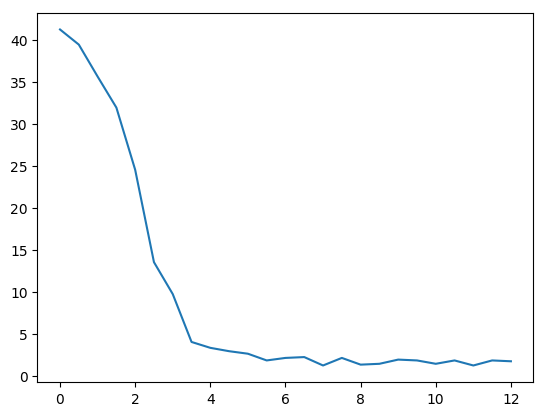

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002E274A90>

In [59]:
plot(th_vec, crashes[:,47]/10)

In [29]:
best_succ

73.0

In [30]:
crashes[end, :]

31-element Array{Float64,1}:
 51.0
 34.0
 28.0
 30.0
 39.0
 35.0
 29.0
 32.0
 39.0
 29.0
 30.0
 19.0
 28.0
  ⋮  
 27.0
 21.0
 27.0
 25.0
 19.0
 16.0
 27.0
 21.0
 19.0
 18.0
 15.0
 17.0